# Motivation and Problem Statement

For my MATH 104A (Numerical Analysis) final project, I chose to focus on the Black-Scholes-Merton model. The Black-Scholes-Merton model is a mathematical pricing model that determines the value of European call and put options. It mainly consists of five input variables: current stock price, strike price, interest rate, time to maturity date, and volatility. I decided to estimate the volatility of the Black-Scholes-Merton formula for call options in this project by experimenting with the following three zero-finding methods: Bisection Method, Newton's Method, and Secant Method. To further expand my knowledge with a real-world application, I used the method with the highest accuracy and Yahoo Finance to compare the implied volatility results. This helped me determine whether the relationship between the strike price and implied volatility of Intel Corporation forms a distinct shape. Thus, my report answers the following questions:
-  Which method is the most accurate?
-  Which method has the least amount of iterations?
-  Real-World Application: How will changing the strike price affect volatility?

To answer the first two questions, I solved three calculation problems using Python to test each method. The parameters of the three calculation problems are defined as follows:
1. $s_0= 50, K = 55, r= 0.1, T= 0.5, c= 2.50$
2. $s_0= 50, K = 70, r= 0.2, T= 0.7, c= 2$
3. $s_0= 100, K = 100, r= 0.1, T= 0.5, c= 5$.

The cell below imports the packages I used throughout this project.

In [1]:
import numpy as np
import scipy.stats as sp
import scipy as sci
import sympy as sy
import math as m
import datetime as dt
import matplotlib.pyplot as plt 
import pandas_datareader.data as web

# Methods and Validation

The Black-Scholes-Merton formula for call options is defined as 
\begin{align}
C(s_0, K, T) = s_0N(d_1) - Ke^{-rT}N(d_2)
\end{align}
where
\begin{align}
d_1 = \frac{1}{\sigma\sqrt{T}}(log{\frac{s_0}{K}} + (r + \frac{\sigma^2}{2})T)
\end{align}
\begin{align}
d_2 = \frac{1}{\sigma\sqrt{T}}(log{\frac{s_0}{K}} + (r - \frac{\sigma^2}{2})T)
\end{align}
\begin{align}
N(d) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{d} e^{\frac{-y^2}{2}} \,dy.
\end{align}

In [2]:
def bs_call(s, k, r, t, sig):
    
    d1 = (1/(sig * np.sqrt(t))) * (np.log(s/k) + (r + ((1/2) * (sig ** 2))) * t)
    d2 = (1/(sig * np.sqrt(t))) * (np.log(s/k) + (r - ((1/2) * (sig ** 2))) * t)
    
    c = (s * sp.norm.cdf(d1)) - (k * np.exp(-r*t)*sp.norm.cdf(d2))
    
    return c

Note its similarity to the Black-Scholes-Merton formula for put options:
\begin{align}
P(s_0, K, T) = Ke^{-rT}N(-d_2)-s_0N(-d_1).
\end{align}

In [3]:
def bs_put(s, k, r, t, sig):
    
    d1 = (1/(sig * np.sqrt(t))) * (np.log(s/k) + (r + ((1/2) * (sig ** 2))) * t)
    d2 = (1/(sig * np.sqrt(t))) * (np.log(s/k) + (r - ((1/2) * (sig ** 2))) * t)
    
    p = (k * np.exp(-r*t) * sp.norm.cdf(-d2)) - (s * sp.norm.cdf(-d1))
    
    return p

Thus, this project solely focuses on call options to avoid redundancy.

The calculations regarding the implied volatility can be written as a fixed-point problem 
\begin{align}
f(\sigma) = \sigma = C(s_0, K, T) - c.
\end{align}
The interval $(0.001, 0.7)$ is chosen because it provides a function $f(\sigma)$ that is continuous and differentiable. In addition, $f(\sigma) \in  (0.001, 0.7)$ for all $ \sigma \in (0.001, 0.7)$. Consequently, there exists at least one fixed point in the interval and the following zero-finding methods can be used to solve these problems.

The Bisection method works for these calculations because it can be shown through plugging in the variables with the interval where $a = 0.001$ and $b = 0.7$ that $f(a)$ and $f(b)$ are of opposite signs. Therefore, the Intermediate Value Theorem implies that there is a number $p \in (a, b)$ where $f(p) = 0$. Thus, it helps estimate a zero where
\begin{align}
|p_n - p| \le \frac{b-a}{2^n},
\end{align}
for $n \ge 1.$

In [4]:
def bs_vol_b_call(s, k, r, t, price, a, b, tol, n0):
    
    def f(sig):
        return bs_call(s, k, r, t, sig) - price
    
    i = 1
    fa = f(a)
    
    while i<=n0:
        
        if i>=2:
            p0 = p
        
        p = a + (b-a)/2
        fp = f(p)
        
        if (fp == 0) or ((b-a/2)<tol):
            print('p = ',p)
            print('i = ',i)
            print('absolute error = ', abs((p-p0)))
            print('relative error = ', abs((p-p0)/p))
            break
        
        i += 1
        
        if (fa*fp > 0):
            a = p
            fa = fp
        else: 
            b = p

The next method, Newton's method, is defined as follows:

\begin{align}
p_n= g(p_{n-1})= p_{n-1} - \frac{f(p_{n-1})}{f'(p_{n-1})},
\end{align}

for $n \ge 1$.

To find the implied volatility using Newton's method, the partial derivative of the call option price with respect to the implied volatility (also known as Vega) must be computed:

\begin{align}
\frac{\partial C}{\partial\sigma} = \frac{s_0\sqrt{T}e^{\frac{-d_{1}^{2}}{2}}}{\sqrt{2\pi}},
\end{align}

where $\frac{\partial C}{\partial\sigma} > 0$.

This implies that Newton's method works in finding a convergent $p \in (a,b)$ given any initial approximation $p_0$ such that $p_0 \in [p - \delta, p + \delta]$ where $\delta > 0$ since $f(p) = 0$ and $f'(p) \neq 0$.

In [5]:
def bs_vol_nm_call(s, k, r, t, price, p0, tol, n0):
    
    def f(sig):
        return bs_call(s, k, r, t, sig) - price
    
    def fprime(sig):
        const = 1/(sig * np.sqrt(t))
        d1 = const * (np.log(s/k) + (r + ((1/2) * (sig ** 2))) * t)
        return np.sqrt(t) * s * sp.norm.pdf(d1)
    
    i = 1
    
    while i<=n0:
        
        f_new = f(p0)
        fprime_new = fprime(p0)
        
        p = p0 - (f_new/fprime_new)
        p = float(p)
        
        if (np.abs(p-p0) < tol):
            print('p = ', p)
            print('i = ', i)
            print('absolute error = ', abs((p-p0)))
            print('relative error = ', abs((p-p0)/p))
            break
        
        i += 1
        
        p0 = p
        
    if i>n0:
        print('The method failed after N0 iterations, N0 = ', n0)

Newton's method can be rewritten to eliminate the need for a partial derivative evaluation. This results in the Secant Method:

\begin{align}
p_n=p_{n-1} - \frac{f(p_{n-1})(p_{n-1} - p_{n-2})}{f(p_{n-1})-f(p_{n-2})}.
\end{align}

In this case, two initial approximations are needed as opposed to the one initial approximation in Newton's method. Therefore, the Secant method should need slightly more iterations to obtain an answer compared to Newton's method.

In [6]:
def bs_vol_s_call(s, k, r, t, price, p0, p1, tol, n0):
    
    def f(sig):
        return bs_call(s, k, r, t, sig) - price
    
    num = 2
    i = num - 1
    
    q0 = f(p0)
    q1 = f(p1)
    
    while num<=n0:
        
        p = p0 - (p1-p0)*q0/(q1 - q0) 
        
        if abs(p-p1) < tol:
            
            print('p = ',p)
            print('i = ',i)
            print('absolute error = ', abs((p-p1)))
            print('relative error = ', abs((p-p1)/p))
            break
            
        num += 1
        i += 1
        
        p0 = p1
        q0 = q1
        p1 = p
        q1 = f(p)

Note that the absolute error and relative error are defined as follows to compare the accuracy of the three methods:
\begin{align}
\text{absolute error} = |p -p^{*}|
\end{align}

\begin{align}
\text{relative error} = \frac{|p -p^{*}|}{p}.
\end{align}

# Results and Summary

The outputs of each calculation using Python are shown below:

In [7]:
print('CALCULATION #1:')
print('Bisection Method')
bs_vol_b_call(50, 55, 0.1, 0.5, 2.5, 10**(-3), 0.7, 10**(-9), 100)

print('------------------------------')

print('Newton\'s Method')
bs_vol_nm_call(50, 55, 0.1, 0.5, 2.5, 0.15, 10**(-9), 100)

print('------------------------------')

print('Secant Method')
bs_vol_s_call(50, 55, 0.1, 0.5, 2.5, 0.045, 0.06, 10**(-9), 100)

CALCULATION #1:
Bisection Method
p =  0.24555458969853775
i =  51
absolute error =  3.0531133177191805e-16
relative error =  1.2433542054609626e-15
------------------------------
Newton's Method
p =  0.2455545896985378
i =  4
absolute error =  2.237654506132003e-13
relative error =  9.11265600402389e-13
------------------------------
Secant Method
p =  0.2455545896985379
i =  6
absolute error =  1.4535594949904862e-12
relative error =  5.919496339999142e-12


In [8]:
print('CALCULATION #2:')
print('Bisection Method')
bs_vol_b_call(50, 70, 0.2, 0.7, 2, 10**(-3), 0.7, 10**(-9), 100)

print('------------------------------')

print('Newton\'s Method')
bs_vol_nm_call(50, 70, 0.2, 0.7, 2, 0.15, 10**(-9), 100)

print('------------------------------')

print('Secant Method')
bs_vol_s_call(50, 70, 0.2, 0.7, 2, 0.045, 0.5, 10**(-9), 100)

CALCULATION #2:
Bisection Method
p =  0.3213201631874866
i =  51
absolute error =  2.7755575615628914e-16
relative error =  8.637981301980685e-16
------------------------------
Newton's Method
p =  0.3213201631874865
i =  6
absolute error =  4.996003610813204e-16
relative error =  1.5548366343565235e-15
------------------------------
Secant Method
p =  0.32132016318748624
i =  7
absolute error =  4.18554080283684e-14
relative error =  1.3026075803386886e-13


In [9]:
print('CALCULATION #3:')
print('Bisection Method')
bs_vol_b_call(100, 100, 0.1, 0.5, 5, 10**(-3), 0.7, 10**(-9), 100)

print('------------------------------')

print('Newton\'s Method')
bs_vol_nm_call(100, 100, 0.1, 0.5, 5, 0.15, 10**(-9), 100)

print('------------------------------')

print('Secant Method')
bs_vol_s_call(100, 100, 0.1, 0.5, 5, 0.045, 0.7, 10**(-9), 100)

CALCULATION #3:
Bisection Method
p =  0.050041632022357535
i =  51
absolute error =  3.0531133177191805e-16
relative error =  6.101146574026831e-15
------------------------------
Newton's Method
p =  0.05004163202235638
i =  6
absolute error =  5.059522245609571e-12
relative error =  1.0110625975086506e-10
------------------------------
Secant Method
p =  0.05004163202235787
i =  7
absolute error =  2.5585020213547693e-12
relative error =  5.112746962792237e-11


The Bisection method is the most accurate zero-finding method. This is shown with its absolute and relative error compared to the other methods. On the other hand, Newton's Method has the least amount of iterations for all three calculations. In fact, Newton's method processed less than seven iterations while the Bisection method processed fifty-one iterations for each computation. This implies that there exists a trade-off between accuracy and the amount of iterations.

The Secant method also processed less iterations than the Bisection method, but it completed a slightly higher amount of iterations compared to Newton's method. For example, in the first computation, the Secant method needed six iterations while Newton's method only needed four iterations. This makes sense because theoretically, the simplification of the Secant method eliminates the need for the derivative of the original function that is present in Newton's method. As a result, a trade-off for more iterations occurs. The Secant method, however, did not do as well as the other two methods in terms of accuracy with the exception of the third calculation.

After discovering that the Bisection method is the most accurate zero-finding method, I implemented it to find the implied volatility among different strike prices, given the same date of maturity. I compared these calculations with the information provided by Yahoo Finance. It turns out the calculations using the Bisection method are predominantly higher than the actual implied volatility of Intel for various strike prices, as shown below. Note that plotting these implied volatilities with the strike price creates a smile-like shape. The strike prices further away from the current stock price have higher implied volatility than those that are closer to it, which results in what is known as the volatility smile.

In [10]:
def bs_vol_bisection_call_yf(s, k, r, t, price, a, b, tol, n0):
    
    def f(sig):
        return bs_call(s, k, r, t, sig) - price
    
    num = sci.optimize.bisect(f, a, b)
    
    return num

<ipython-input-2-8aa2a709575e>:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (1/(sig * np.sqrt(t))) * (np.log(s/k) + (r + ((1/2) * (sig ** 2))) * t)
<ipython-input-2-8aa2a709575e>:4: RuntimeWarning: divide by zero encountered in double_scalars
  d2 = (1/(sig * np.sqrt(t))) * (np.log(s/k) + (r - ((1/2) * (sig ** 2))) * t)


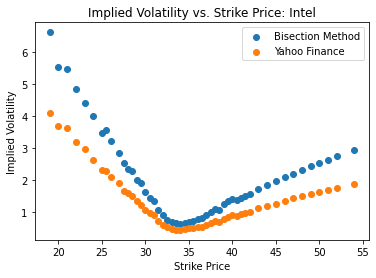

In [11]:
intc = web.YahooOptions('INTC')
intc.headers = {'User-Agent': 'Firefox'}
c = intc.get_call_data()
c.reset_index(inplace=True)
c['Time'] = (c.Expiry - dt.datetime.now()).dt.days / 250 #250 trading days

lst_call = []

for i in c.itertuples():
    v_call = bs_vol_bisection_call_yf(i.Underlying_Price, i.Strike, 0, i.Time, i.Ask, -10000, 10000, 10**(-8), 100)
    lst_call.append(v_call)
    
plt.scatter(c.Strike, lst_call, label='Bisection Method')
plt.scatter(c.Strike, c.IV, label='Yahoo Finance')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility vs. Strike Price: Intel')
plt.legend() 

Although the Bisection method offers the highest accuracy when calculating implied volatility in the Black-Scholes-Merton model, all three of the zero-finding methods mentioned above are crucial to understanding numerical analysis and the mathematics that exists around us.
